# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == '>50K'].shape[0]

# Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == '<=50K'].shape[0]

# Percentage of individuals whose income is more than $50,000
greater_percent = float(100*n_greater_50k)/n_records

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

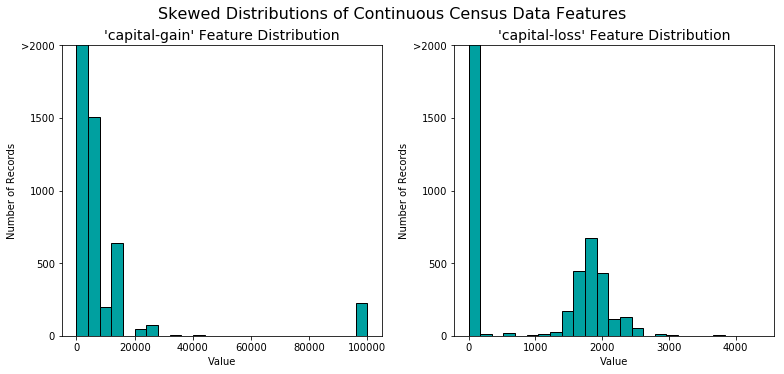

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

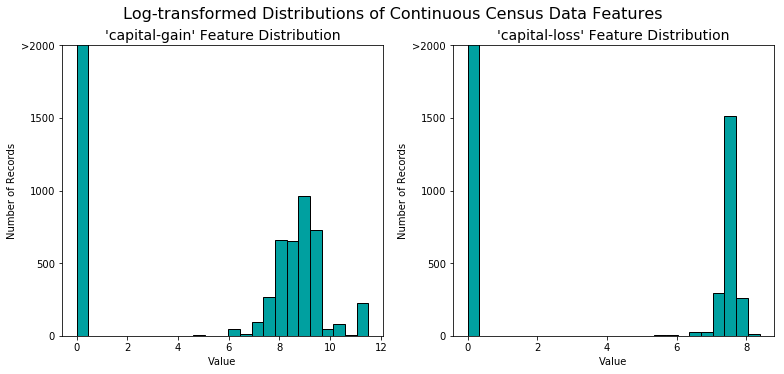

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
# features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log1p(x))


# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
# income = income_raw.apply(lambda x: 0 if(x=='<=50K') else 1)
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
income = encoder.fit_transform(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
pred = [1 for i in income]

true_positives = sum(map(lambda x,y: 1 if x==1 and y==1 else 0, income, pred)) 
false_positives = sum(map(lambda x,y: 1 if x==0 and y==1 else 0, income, pred)) 
true_negatives = sum(map(lambda x,y: 1 if x==0 and y==0 else 0, income, pred)) 
false_negatives = sum(map(lambda x,y: 1 if x==1 and y==0 else 0, income, pred))

# Calculate accuracy, precision and recall
from __future__ import division
accuracy = float(true_positives+true_negatives)/n_records
precision = float(true_positives)/(true_positives+false_positives)
recall = float(true_positives)/(true_positives+false_negatives)

# Calculate F-score using the formula above for beta = 0.5
beta = 0.5
fscore = (1+beta**2) * (precision*recall)/((precision*beta**2)+recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

# Check the results with sklearn
# from sklearn.metrics import accuracy_score, fbeta_score
# sklearn_accuracy = accuracy_score(income, pred)
# sklearn_fscore = fbeta_score(income, pred, beta)
# print "Sklearn Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(sklearn_accuracy, sklearn_fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

----
**Answer: **

I would like to elaborate on my answer to this question, as it helps me to clear and document my thoughts and findings. First, I want to review the important considerations when choosing machine learning algorithms:

* `Type of problem:` It is obvious that algorithms have been designd to solve specific problems. So, it is important to know what type of problem we are dealing with and what kind of algorithm works best for each type of problem. I don't want to go into much detail but at high level, machine learning algorithms can be classified into Supervised, Unsupervised and Reinforcement learning. Supervised learning by itself can be categorized into Regression, Classification, and Anomoly Detection.


* `Size of training set:` This factor is a big player in our choice of algorithm. For a small training set, high bias/low variance classifiers (e.g., Naive Bayes) have an advantage over low bias/high variance classifiers (e.g., kNN), since the latter will overfit. But low bias/high variance classifiers start to win out as training set grows (they have lower asymptotic error), since high bias classifiers aren’t powerful enough to provide accurate models [1].


* `Accuracy:` Depending on the application, the required accuracy will be different. Sometimes an approximation is adequate, which may lead to huge reduction in processing time. In addition, approximate methods are very robust to overfitting.


* `Training time:` Various algorithms have different running time. Training time is normally function of size of dataset and the target accuracy.


* `Linearity:` Lots of machine learning algorithms such as linear regression, logistic regression, and support vector machines make use of linearity. These assumptions aren't bad for some problems, but on others they bring accuracy down. Despite their dangers, linear algorithms are very popular as a first line of attack. They tend to be algorithmically simple and fast to train.


* `Number of parameters:` Parameters affect the algorithm's behavior, such as error tolerance or number of iterations. Typically, algorithms with large numbers parameters require the most trial and error to find a good combination. Even though having many parameters typically provides greater flexibility, training time and accuracy of the algorithm can sometimes be quite sensitive to getting just the right settings.


* `Number of features:` The number of features in some datasets can be very large compared to the number of data points. This is often the case with genetics or textual data. The large number of features can bog down some learning algorithms, making training time unfeasibly long. Some algorithms such as Support Vector Machines are particularly well suited to this case [2,3]. 

Below is an algorithm cheatsheet provided by scikit-learn (works as rule of thumb), which I believe it has implicitely considered all the above factors in making recommendation for choosing the right algorithm. But it doesn't work for all situations and we need to have a deeper understanding of these algorithms to employ the best one for a unique problem.

<img src="pictures/ml_map.png">


I am choosing the following 3 algorithms and I will explain why I believe they are more appropriate for the case of this problem.

----
### K-Nearest Neighbors

Nearest Neighbors provides functionality for unsupervised and supervised (regression and classification) neighbors-based learning methods. It is a type of instance-based learning, or lazy learning algorithms where the function is only approximated locally and all computation is deferred until classification. The KNN algorithm is amongst the simplest of all machine learning algorithms. 


*A) Real-world application*

A very nice post in Quora [4] presents nice applications of kNN. According to this post, one category of application is *kNN Search* where it is used to search for similar items. The way it measures similarity is by creating a vector representation of the items, and then compare the vectors using an appropriate distance metric. Some examples of this application is *Concept Search* (semantic analysis) and *Recommender Systems*.
<br />

Another application is *kNN Classification* mostly in the context of *Visual Pattern Recognition* [5]. Face recognition and theft prevention in the retail business are examples of this type of application. Feature vectors are extractd from images and video frames and then, kNN is used to find similar objects. k-NN isn’t as sexy as a neural network or an SVM, and generally runs slower and has lower accuracy than those approaches, but it’s got some nice practical qualities. It is good enough and there is no need for a more complex algorithm. More importantly, it’d be impractical to train a separate classifier for each person on the watchlist.


*B) Strengths of the model*

* It is a simple but powerful algorithm.
* Complex concepts can be learned by local approximation using simple procedures.
* It involves no training (lazy) and thus, cost of the learning process is zero.
* New training examples can be added easily.
* It naturally handles multi-class cases.
* It is efficient in practice with enough representative data.
* Being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.

*C) weaknesses of the model*

* Value of parameter k needs to be determined.
* Algorithm is sensetive to the type of distance and subset of attributes (which attribute to use to produce the best results?).
* It is computationally expensive (and slow) to find the k nearest neighbours when the dataset is very large (O(md), m = # examples, d = # dimensions)
* It does not perform well at large dimensions.
* The model can not be interpreted (there is no description of the learned concepts).

*D) why this model is a good candidate for this problem?*

* Our problem is a classification problem. Discriminative models such as kNN and ensemble methods outperform generative models such as Naive Bayes in classification problems. 
* It is a simple method and I am going to use it as a base model to comapre with more complex algorithms such as ensemble methods. I could use logistic regression (LR) for this purpose but LR is linear and based on my experience, it is rare to have linearly separable data. So it's usually better to directly apply a non-linear model. 
* We have enough data points (almost 40K) and not too many features (103) which is ideal for kNN to perform well. It may not have a good running time performance, but accuracy is more important to us than the training time in this case.  

---

### Ensemble Methods

In this section, I am going to discuss ensemble methods in general and then compare two popular ensemble methods, Random Forests (RM) and Gradient Boosting Machine (GBM).

Ensemble methods combine multiple hypotheses to form a better hypothesis (hopefully). All ensemble methods share the following 2 steps:

* Producing a distribution of simple models on subsets of the original data
* Combining the distribution into one "aggregated" model

The term ensemble is usually reserved for methods that generate multiple hypotheses using the same base learner. The broader term of multiple classifier systems also covers hybridization of hypotheses that are not induced by the same base learner. An ensemble itself is a learning algorithm, because it can be trained and then used to make predictions. The trained ensemble, therefore, represents a single hypothesis. Empirically, ensembles tend to yield better results when there is a significant diversity among the models. Many ensemble methods, therefore, seek to promote diversity among the models they combine [6].



*Common types of ensembles*

* `Simple averaging:` One of the most popular ways of combining multiple hypotheses is through simply averaging of the corresponding output values. It is considered a too simple but very effective ensemble method. It achieves most of the benefits of ensembles in reducing the variance of the estimate of the output class posteriors.


* `Stacking (stacked generalization):`  The main concept is to use a new classifier to correct the errors of a previous classifier, hence the classifier are stacked on top of one another. It involves training a learning algorithm to combine the predictions of several other learning algorithms. First, all of the other algorithms are trained using the available data, then a *combiner algorithm* is trained to make a final prediction using all the predictions of the other algorithms as additional inputs. Theoretically, any arbitrary combiner algorithm can be used, although in practice, a single-layer logistic regression model is often used as the combiner.


* `Bootstrap Aggregating (Bagging):` This algorithm generates multiple bootstrap training sets from the original training set and uses each of them to generate a classifier for inclusion in the ensemble. In general, bagging does more to *reduce the variance* in the base models than the bias, so bagging performs best relative to its base models when the base models have high variance and low bias. Decision trees are unstable, which explains why *bagged decision trees* often outperform individual decision trees. Similarly, bagging, or in general bootstrapping works well for neural network classifiers. However, Naive Bayes classifiers or kNN classifiers are stable, which explains why bagging is not particularly effective for Naive Bayes or kNN classifiers [7].


* `Boosting:` This algorithm involves incrementally building an ensemble by training each new model instance to emphasize the training instances that previous models mis-classified. Boosting does more to *reduce bias* than variance. For this reason, boosting tends to improve upon its base models most when they have high bias and low variance. Examples of such models are *Naive Bayes classifiers and decisions tumps*. Boosting’s bias reduction comes from the way it adjusts its distribution over the training set. However, this method of adjusting the training set distribution causes boosting to have difficulty *when the training data are noisy*. It is because the weights assigned to noisy examples often become much higher than for the other examples, often causing boosting to focus too much on those noisy examples and overfit the data [7]. 


*Advantages of ensemble methods*

* Intuitively, ensembles allow the different needs of a difficult problem to be handled by hypotheses suited to those particular needs. 
* Mathematically, ensembles provide an extra degree of freedom in the classical bias/variance tradeoff, allowing solutions that would be difficult (if not impossible) to reach with only a single hypothesis. 
* They're unlikely to overfit.

*Disadvantages of ensemble methods*

* The model that is closest to the true data generating process will always be best and will beat most ensemble methods. So if the data come from a linear process, linear models will be much superior to ensemble models.

* Ensemble models suffer from lack of interpretability. Sometimes we need predictions and explanations of the predictions. It is hard to convince people to act on predictions when the methods are too complex for their comfort level. Variable importance analysis can help with insights, but if the ensemble is more accurate than a linear additive model, the ensemble is probably exploiting some non-linear and interaction effects that the variable importance analysis can't completely account for [8].

* Ensemble methods are usually computationally expensive. Therefore, they add learning time and memory constrains to the problem.

---

### Gradient Boosting vs Random Forest

GBM and RF both are ensemble learning methods and predict (regression or classification) by combining the outputs from individual trees (we assume tree-based GBM or GBT). They have all the strengths and weaknesses of the ensemble methods mentioned above. So, here we compare them only with respect to each other. 

GBM and RF differ in the way the trees are built: the order and the way the results are combined. It has been shown that GBM performs better than RF if parameters tuned carefully [9,10].

> **Note:** A very importnat point regarding how RF and GBM methods are handling *missing data*. Gradient Boosting Trees uses CART trees (in a standard setup, as it was proposed by its authors). CART trees are also used in Random Forests. CART handles missing values either by imputation with average, either by rough average/mode, either by an averaging/mode based on proximities. However, one can build a GBM or RF with other type of decision trees. The usual replacement for CART is C4.5 proposed by Quinlan. In C4.5 the missing values are not replaced on data set. Instead, the impurity function computed takes into account the missing values by penalizing the impurity score with the ratio of missing values [16].

---

**Gradient Boosting:** GBT build trees one at a time, where each new tree helps to correct errors made by previously trained tree.

*A) Real-world application*

A great application of GBM is *anomaly detection* in supervised learning settings where data is often highly *unbalanced* such as DNA sequences, credit card transactions or cyber security. 

Reference [11] presents a more specific application in this context, supervised anomaly detection task with a *learning to rank approach*. Learning to rank means application of machine learning in the construction of ranking models for information retrieval systems. This results in finding the anomalies with the highest precision without giving too many genuine examples to the experts. According to this manuscript, gradient boosting has shown to be a powerful method on real life datasets to address learning to rank problems due to its two main features: 

* It performs the optimization in function space (rather than in parameter space) which makes the use of custom loss functions much easier. 
* Boosting focuses step by step on difficult examples that gives a nice strategy to deal with unbalanced datasets by strengthening the impact of the positive class.


*B) Strengths of the model*
* Since boosted trees are derived by optimizing an objective function, basically GBM can be used to solve almost all objective function that we can write gradient out. This including things like ranking and poission regression, which RF is harder to achieve.


*C) Weaknesses of the model*
* GBMs are more sensitive to overfitting if the data is noisy.
* Training generally takes longer because of the fact that trees are built sequentially. 
* GBMs are harder to tune than RF. There are typically three parameters: number of trees, depth of trees and learning rate, and the each tree built is generally shallow.

---

**Random Forest:** RFs train each tree independently, using a random sample of the data. This randomness helps to make the model more robust than a single decision tree, and less likely to overfit on the training data [9,10]. 

*A) Real-world application*

The most prominent application of random forest is *multi-class object detection* in large-scale real-world *computer vision* problems [12]. RF methods can handle large amount of training data efficiently and are inherently suited for multi-class problems.

Another application is in *bioinformatics*, like medical diagnosis [13]. This method is especially attractive for this application in the following cases:
* The real world data is noisy and contains many missing values, some of the attributes are categorical, or semi-continuous.
* There are needs to integrate different data sources which face the issue of weighting them.
* We need high predictive accuracy for a high-dimensional problem with highly correlated features.

*B) Strengths of the model*
* RF are much easier to tune than GBM. There are typically two parameters in RF: number of trees and number of features to be selected at each node.
* RF are harder to overfit than GBM.


*C) weaknesses of the model*
* The main limitation of the Random Forests algorithm is that a large number of trees may make the algorithm slow for real-time prediction.
* For data including categorical variables with different number of levels, random forests are biased in favor of those attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data. Methods such as partial permutations were used to solve the problem [15].
* If the data contain groups of correlated features of similar relevance for the output, then smaller groups are favored over larger groups [15].

*D) why this model is a good candidate for this problem?*

I am going to use RF for this problem. It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier. It is a discriminative moldel and it is easier to tune than GBM.  

---

### Support Vector Machines (SVM)

SVMs are a set of supervised learning methods used for classification, regression and outliers detection. The basic idea is to find a hyperplane which separates the d-dimensional data perfectly into its two classes. Overall, SVM’s are intuitive, theoretically well-founded, and have shown to be practically successful [17].

*A) Real-world application*

Wikipedia presents several applications that SVM shows great performance including *text and hypertext categorization*, *image classification*, *hand-written characters recognition*, and *biological science*. I just explain about text categorization and why SVM is charming for this application [18].

The goal of text categorization is the classi􏰂cation of documents into a 􏰂fixed number of predefi􏰂ned categories.􏰊 Each document can be in multiple,􏰈 exactly one, or no category at all. Why SVM work well for this application?
* High dimensional input space􏰀: When learning text classifi􏰂ers􏰈 one has to deal with too many features. Since SVM does not necessarily depend on the number of features,􏰈 it has the potential to handle these large feature spaces.
* Document vectors are sparse􏰀: SVM is well suited for problems with dense concepts and sparse instances.
* Most text categorization problems are linearly separable􏰀 [19].


*B) Strengths of the model*
* Flexibility in choosing a similarity function
* Sparseness of solution when dealing with large data sets as only support vectors are used to specify the separating hyperplane 
* Ability to handle large feature spaces (even effective in cases where number of dimensions is greater than the number of samples)
* Overfitting can be controlled by soft margin approach
* Nice math property: a simple convex optimization problem which is guaranteed to converge to a single global solution
* Non-linear decision boundaries can be obtained using kernel trick

*C) Weaknesses of the model*

* Perhaps the biggest limitation of the support vector approach lies in choice of the kernel
* A second limitation is speed and size, both in training and testing
* The optimal design for multiclass SVM classifiers is a further area for research
* Although SVMs have good generalization performance, they can be abysmally slow in test phase
* From a practical point of view, perhaps the most serious problem with SVMs is the high algorithmic complexity and extensive memory requirements of the required quadratic programming in large-scale tasks [20].
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation.

> **Note:** SVM ability to deal with noise depends on the noise strength and kernel used. For high-bias kernels such as linear or polynomial, noise should not the the problem. However, for low-bias kernels like RBF, it will affect classification.

*D) why this model is a good candidate for this problem?*

SVM has a good potential to work well for binary classification problems such as our problem. 

---
**References**

    Model Selection
    
1. [Choosing a Machine Learning Classifier](http://blog.echen.me/2011/04/27/choosing-a-machine-learning-classifier/)
2. [Comparing supervised learning algorithms](http://www.dataschool.io/comparing-supervised-learning-algorithms/)
3. [How to choose algorithms for Microsoft Azure Machine Learning](https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-algorithm-choice)

    `Nearest Neighbors`
    
4. [What are industry applications of the K-nearest neighbor algorithm?](https://www.quora.com/What-are-industry-applications-of-the-K-nearest-neighbor-algorithm)
5. [Solving Real-World Problems with Nearest Neighbor Algorithms](http://www.dummies.com/programming/big-data/data-science/solving-real-world-problems-with-nearest-neighbor-algorithms/)

    `Ensemble Methods`
    
6. [Ensemble Learning (wikipedia)](https://en.wikipedia.org/wiki/Ensemble_learning)
7. [Classifier ensembles: Select real-world applications](https://www.researchgate.net/publication/222425707_Classifier_ensembles_Select_real-world_applications)
8. [When should I not use an ensemble classifier?](https://stats.stackexchange.com/questions/158382/when-should-i-not-use-an-ensemble-classifier)

    `Random Forest vs Gradient Boosting`
    
9. [When would one use Random Forests over Gradient Boosted Machines?](https://www.quora.com/When-would-one-use-Random-Forests-over-Gradient-Boosted-Machines-GBMs)
10. [What are the advantages/disadvantages of using Gradient Boosting over Random Forests?](https://www.quora.com/What-are-the-advantages-disadvantages-of-using-Gradient-Boosting-over-Random-Forests)
11. [Efficient top rank optimization with gradient boosting for supervised anomaly detection](http://ecmlpkdd2017.ijs.si/papers/paperID241.pdf)
12. [An Introduction to Random Forests for Multi-class Object Detection](https://pdfs.semanticscholar.org/9035/e87ce49b67b751838c7346d36fe481260217.pdf)
13. [Using Random Forest for Reliable Classification and Cost-Ssensitive Learning for medical diagnosis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2648734)
14. [Random Forest - Features and Advantages](http://www.liquisearch.com/random_forest/features_and_advantages)
15. [Random Forest - Disadvantages](http://www.liquisearch.com/random_forest/disadvantages)
16. [Why doesn't Random Forest handle missing values in predictors?](https://stats.stackexchange.com/questions/98953/why-doesnt-random-forest-handle-missing-values-in-predictors)

    `Support Vector Machine`
17. [Introduction to Support Vector Machines](http://dustwell.com/PastWork/IntroToSVM.pdf)
18. [Support vector machine (wikipedia)](https://en.wikipedia.org/wiki/Support_vector_machine)
19. [Text Categorization with Support Vector Machines](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf)
20. [Disadvantages of Support Vector Machines](http://www.svms.org/disadvantages.html)


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(predictions_train, y_train[:300])
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(predictions_test, y_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(predictions_train, y_train[:300], beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(predictions_test, y_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


/Users/aravanshad/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.


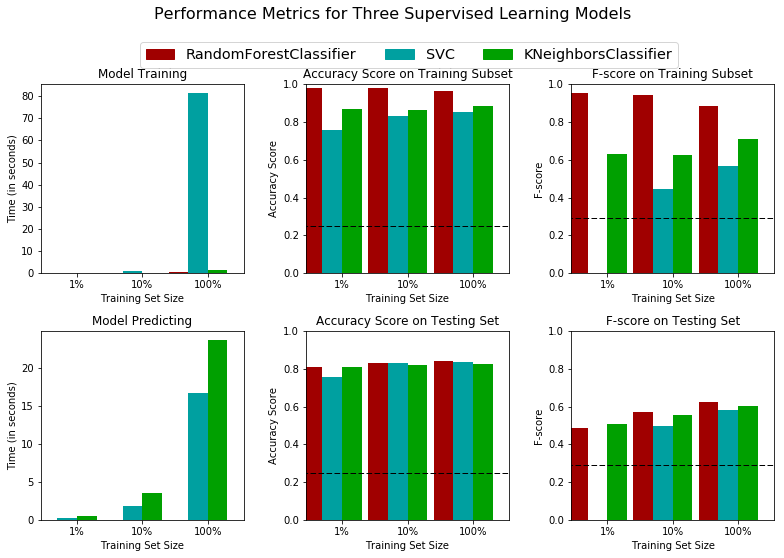

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = RandomForestClassifier(random_state=123)
clf_C = SVC(random_state=123)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = len(y_train)//10
samples_1 = len(y_train)//100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

I recommend "Random Forest" model to be used in this problem. As it can be seen in the graph, RF outperforms kNN and SVC by all metrics which makes decision-making very easy. Below, I provide more technical support for my decision:


* As expected, all three models had a relatively good performance with respect to F-score on the testing data when 100% of the training data is used. RF showed slightly better performance than kNN, and kNN showed slighly better performance than SVC. It seems that SVC performance is affected by size of training dataset.


* RF also showed the best running time performance in both training and testing phases. As expected, kNN had almost zero training time and longest testing time. SVC showed very poor training/testing time performance. 


* Undoubtedly, RF is the best fit for this problem as it is the fastest and most accurate model among all three models which showed the best performance using the partial or entire training dataset. In addition, RF provides some level of interpretibility through its feature importance analysis. It also has only two hyperparemetr which makes the fine-tuning task very easy.


### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

Random Forest (RF) is an ensemble approach. Ensemble methods combine the predictions of several base estimators built with a given learning algorithm in order to improve generalization power and robustness over a single estimator. Decision Tree (DT) algorithm serves as base learner for random forest ensemble method. In fact, decision trees are building blocks of random forest models.  

DT algorithm clusters the data in groups and subgroups. If you would draw lines between the data points in a subgroup, and lines that connect subgroups into group etc. the structure would look somewhat like a tree. That's why it is called a decision tree. To train a tree in a random forest, at each split m variables are randomly selected from the global variable set to judge whether datapoints have a close relationship or not.

Of the entire set of data a subset is taken (training set). Then multiple trees are built on various sub-samples of training set. Each tree is different because samples are differnt and also, for each split in a tree, variables are chosen at random. Then prediction will be made on the rest of the dataset (not the training set) for each individual tree. Final prediction is a function of each prediction and it can simply be the average of all predictions.



<img src="pictures/RF.jpg" style="width: 800px" />



**Reference**
1. [A Gentle Introduction to Random Forests, Ensembles, and Performance Metrics in a Commercial System](http://blog.citizennet.com/blog/2012/11/10/random-forests-ensembles-and-performance-metrics)
2. [Does random forest select a subset of features for every tree or every node?](https://www.quora.com/Does-random-forest-select-a-subset-of-features-for-every-tree-or-every-node)

---

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = RandomForestClassifier(verbose=0, random_state=123)

# Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
              'n_estimators' : range(10,520,50), 
              'max_depth' : range(3,12,2)
             }

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,
                        param_grid = parameters, 
                        scoring = scorer,
                        n_jobs=4,
                        iid=False, 
                        cv=5)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8395
F-score on testing data: 0.6760

Optimized Model
------
Final accuracy score on the testing data: 0.8566
Final F-score on the testing data: 0.7303


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**? 

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.2478       |     0.8395        |    0.8566       |
| F-score        |        0.2917       |     0.6760        |    0.7303       |


**Answer: **

By looking at the scores in the above table, it can be observed that smarter models perform significantly better in comparison with the naive benchmark predictor. We can also observe that fine-tuning can improve the performance by a few percent.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

To my opinion, the five following features are most important for prediction:

1. **`age :`** people are normally making more money as they are getting older. It is because they are getting more experienced in their career.
2. **`education-num :`** Naturally, higher the education level, higher the income. My guess is this feature be correlated with "education_level", but algorithm will peak this feature as it is a numeric feature.
3. **`hours-per-week :`** I think this feature more helps algorithm to find people with salary less than 50K. It is because if someone works less than 40 hours per week, this means the job is part-time and the income is more probable to be less than 50K.
4. **`capital-gain :`** someone who makes a large profit from the sale of property or of an investment, his income probably is more than 50K. However, I cannot make the same statement about "capital-loss".
5. **`occupation :`** it is reasonable to me that people in a certain occupation class e.g. "Exec-managerial" have income more than 50K.

I believe some features including sex, race, native-country, and relationship should have minor influence on income (at least in USA with strict work regulations).

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

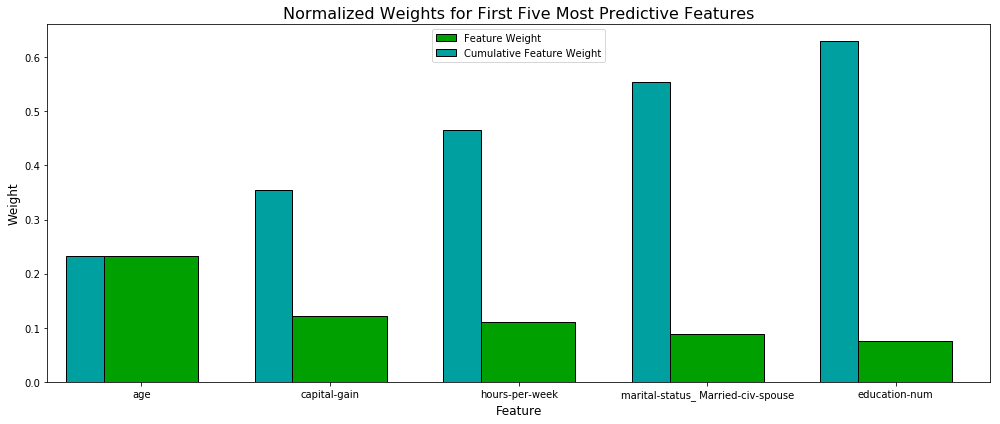

In [12]:
# Import a supervised learning model that has 'feature_importances_'

# Train the supervised model on the training set using .fit(X_train, y_train)
clf = RandomForestClassifier(random_state=123)
model = clf.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

My guess was 80% correct on what features are important, but I was only 40% correct on feature importance order. First, I was thinking that `marital_status` should somehow be correlated with age and my guess was `occupation` must be more important. Hower, the model gives more weight to this feature. In terms of order, I couldn't guess any better as model works with the feature values and is able to more accurately characterize the problem. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8566
F-score on testing data: 0.7303

Final Model trained on reduced data
------
Accuracy on testing data: 0.8480
F-score on testing data: 0.7039


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

Reducing features to five results in reduction in F-score and accuracy of the predictions but this reduction is not significant. When we reduce data, we lose information which obviously results in less accurate model and reduction in performance metrics. In fact, model cannot accurately capture complexity of data structure. Obviously, this is a trade-off between performance and running time. If data is large and it is important to us to reduce time, it would be reasonable to sacrifice a little on performance and make our model faster.  

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.